# Spleen 3D segmentation with MONAI

This tutorial shows how to integrate MONAI into an existing PyTorch medical DL program.

And easily use below features:
1. Transforms for dictionary format data.
1. Load Nifti image with metadata.
1. Add channel dim to the data if no channel dimension.
1. Scale medical image intensity with expected range.
1. Crop out a batch of balanced images based on positive / negative label ratio.
1. Cache IO and transforms to accelerate training and validation.
1. 3D UNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
1. Sliding window inference method.
1. Deterministic training for reproducibility.

![spleen](../figures/spleen0.png)

Target: Spleen  
Modality: CT

## Setup environment

In [1]:
import os

# Set the environment variable to allow duplicate OpenMP libraries
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [2]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel]"
!python -c "import matplotlib" || pip install -q matplotlib
!pip install einops
%matplotlib inline

/bin/bash: /app/miniconda/24.11.1/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /app/miniconda/24.11.1/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /app/miniconda/24.11.1/lib/libtinfo.so.6: no version information available (required by /bin/bash)


## Setup imports

In [3]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
from torch.utils.tensorboard import SummaryWriter
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

print_config()

MONAI version: 1.6.dev2543
Numpy version: 2.3.3
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: bc5f3d1c1abae1389cd0e3d1a0bf3ff56e7f394d
MONAI __file__: /scr/user/<username>/monai/lib/python3.13/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.4
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.16.3
Pillow version: 11.3.0
Tensorboard version: 2.20.0
gdown version: 5.2.0
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 7.1.2
pandas version: 2.3.3
einops version: 0.8.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/i

## Download Dataset from GDrive

In [4]:
import os
import gdown
import zipfile

# Google Drive file ID
file_id = '1UJCFGUexYGPZ__w02Vd2QIucACjT-kyM'

root_dir = os.getcwd()
print(f"Using current directory as root: {root_dir}")

compressed_file = os.path.join(root_dir, "Spleen.zip")
data_root_dir = os.path.join(root_dir, "Task09_Spleen")
final_data_dir = os.path.join(data_root_dir, "Task09_Spleen")
print(f"Using current dataset directory: {final_data_dir}")

# Check if the final data directory already exists
if not os.path.exists(final_data_dir):
    print("Downloading...")
    gdown.download(f'https://drive.google.com/uc?id={file_id}', compressed_file, quiet=False)
    print("Download complete.")

    print("Unzipping...")
    try:
        # Extract the contents to the 'Task09_Spleen' folder, not the nested one
        with zipfile.ZipFile(compressed_file, 'r') as zip_ref:
            zip_ref.extractall(data_root_dir)
        print("Unzipping complete.")
    except zipfile.BadZipFile:
        print("Error: The downloaded file is corrupted or not a valid zip file.")
        if os.path.exists(compressed_file):
            os.remove(compressed_file)
else:
    print("Data directory already exists. Skipping download and extraction.")

Using current directory as root: /scr/user/qmedasia/.bootcamp/monai/nvidia_monai_worksop_1/2_Spleen_Segmentation_3D
Using current dataset directory: /scr/user/qmedasia/.bootcamp/monai/nvidia_monai_worksop_1/2_Spleen_Segmentation_3D/Task09_Spleen/Task09_Spleen
Data directory already exists. Skipping download and extraction.


## Set MSD Spleen dataset path

In [5]:
train_images = sorted(glob.glob(os.path.join(final_data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(final_data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

print(f"Number of training files: {len(train_files)}")
print(f"Number of validation files: {len(val_files)}")

Number of training files: 32
Number of validation files: 9


## Dataset EDA (split counts)

In [ ]:
train_count = len(train_files)
val_count = len(val_files)
test_images = sorted(glob.glob(os.path.join(final_data_dir, "imagesTs", "*.nii.gz")))
test_count = len(test_images)

print(f"Training volumes: {train_count}")
print(f"Validation volumes: {val_count}")
print(f"Test volumes: {test_count}")

split_names = ["Train", "Validation", "Test"]
split_values = [train_count, val_count, test_count]
plt.figure(figsize=(6, 4))
plt.bar(split_names, split_values, color=["#1f77b4", "#ff7f0e", "#2ca02c"])
plt.ylabel("Number of volumes")
plt.title("MSD Spleen split distribution")
for idx, value in enumerate(split_values):
    plt.text(idx, value + 0.5, str(value), ha="center")
plt.tight_layout()
plt.show()


## Set deterministic training for reproducibility

In [6]:
set_determinism(seed=0)

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.

In [7]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=True),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=True),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.


## Visualize training samples with labels

image shape: torch.Size([228, 158, 113]), label shape: torch.Size([228, 158, 113])


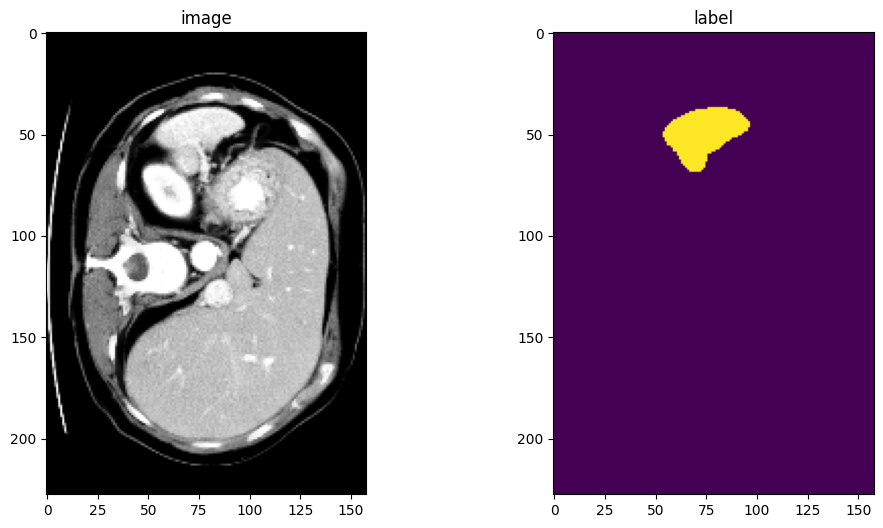

In [8]:
num_samples_to_show = min(3, len(train_files))
if num_samples_to_show == 0:
    raise RuntimeError("No training files found. Please verify the dataset path.")

sample_ds = Dataset(data=train_files[:num_samples_to_show], transform=val_transforms)
sample_loader = DataLoader(sample_ds, batch_size=1, shuffle=False)

fig, axes = plt.subplots(num_samples_to_show, 2, figsize=(10, 4 * num_samples_to_show))
if num_samples_to_show == 1:
    axes = [axes]

for idx, batch in enumerate(sample_loader):
    image = batch["image"][0][0]
    label = batch["label"][0][0]
    volume_name = os.path.basename(train_files[idx]["image"]).replace(".nii.gz", "")
    slice_idx = image.shape[-1] // 2

    axes[idx][0].imshow(image[:, :, slice_idx], cmap="gray")
    axes[idx][0].set_title(f"{volume_name} - image")
    axes[idx][0].axis("off")

    axes[idx][1].imshow(image[:, :, slice_idx], cmap="gray")
    axes[idx][1].imshow(label[:, :, slice_idx], alpha=0.4, cmap="Reds")
    axes[idx][1].set_title(f"{volume_name} - label overlay")
    axes[idx][1].axis("off")

plt.suptitle("Training samples (axial slices)", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

In [9]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=0)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=0)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=0)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=0)

Loading dataset: 100%|██████████| 9/9 [00:17<00:00,  1.90s/it]


## Check VRAM Usage

In [10]:
# Check initial VRAM usage
initial_vram = torch.cuda.memory_allocated()
print(f"Initial VRAM usage: {initial_vram / 1024**2:.2f} MB")

!nvidia-smi

Initial VRAM usage: 0.00 MB
/bin/bash: /app/miniconda/24.11.1/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Sun Nov  9 22:33:26 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.03             Driver Version: 535.216.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  | 00000000:07:00.0 Off |                   On |
| N/A   30C    P0              53W / 400W |     87MiB / 81920MiB |     N/A      Default |
|                   

## Create Model, Loss, Optimizer

In [11]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

# Create a SummaryWriter instance
writer = SummaryWriter()

model_vram = torch.cuda.memory_allocated()
print(f"VRAM after model creation: {model_vram / 1024**2:.2f} MB")

# Reset max memory tracking
torch.cuda.reset_peak_memory_stats()

VRAM after model creation: 18.40 MB


## Execute a typical PyTorch training process

In [12]:
max_epochs = 3  # Increase for better results
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    # Log the average epoch loss to TensorBoard
    writer.add_scalar("Training/Loss", epoch_loss, epoch + 1)

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

            # Log the mean Dice metric to TensorBoard
            writer.add_scalar("Validation/Dice", metric, epoch + 1)

----------
epoch 1/3
1/16, train_loss: 0.6788
2/16, train_loss: 0.6840
3/16, train_loss: 0.6850
4/16, train_loss: 0.6779
5/16, train_loss: 0.6811
6/16, train_loss: 0.6956
7/16, train_loss: 0.6726
8/16, train_loss: 0.6791
9/16, train_loss: 0.6594
10/16, train_loss: 0.6523
11/16, train_loss: 0.6681
12/16, train_loss: 0.6796
13/16, train_loss: 0.6342
14/16, train_loss: 0.6515
15/16, train_loss: 0.6517
16/16, train_loss: 0.6448
epoch 1 average loss: 0.6685
----------
epoch 2/3
1/16, train_loss: 0.6704
2/16, train_loss: 0.6566
3/16, train_loss: 0.6288
4/16, train_loss: 0.6502
5/16, train_loss: 0.6538
6/16, train_loss: 0.6227
7/16, train_loss: 0.6344
8/16, train_loss: 0.6358
9/16, train_loss: 0.6305
10/16, train_loss: 0.6620
11/16, train_loss: 0.6139
12/16, train_loss: 0.5999
13/16, train_loss: 0.6232
14/16, train_loss: 0.6531
15/16, train_loss: 0.6402
16/16, train_loss: 0.6569
epoch 2 average loss: 0.6395
saved new best metric model
current epoch: 2 current mean dice: 0.0315
best mean dice:

In [13]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}"
)

# Close the SummaryWriter
writer.close()

train completed, best_metric: 0.0315 at epoch: 2


## Tensorboard to show the training loss and validation loss

- Vist `http://10.11.132.43:8118/` in the browser for the visualization of the tensorboard.

In [14]:
# %reload_ext tensorboard
%load_ext tensorboard
%tensorboard --logdir runs --host 0.0.0.0 --port 8118

## Check Final VRAM Usage

In [15]:
final_vram = torch.cuda.max_memory_allocated()
print(f"Final Peak VRAM during training: {final_vram / 1024**2:.2f} MB")

print(f"Current VRAM: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")

!nvidia-smi

Final Peak VRAM during training: 1943.83 MB
Current VRAM: 278.06 MB
/bin/bash: /app/miniconda/24.11.1/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Sun Nov  9 22:33:47 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.03             Driver Version: 535.216.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  | 00000000:07:00.0 Off |                   On |
| N/A   30C    P0              53W / 400W |     87MiB / 81920MiB |    

## Plot the loss and metric

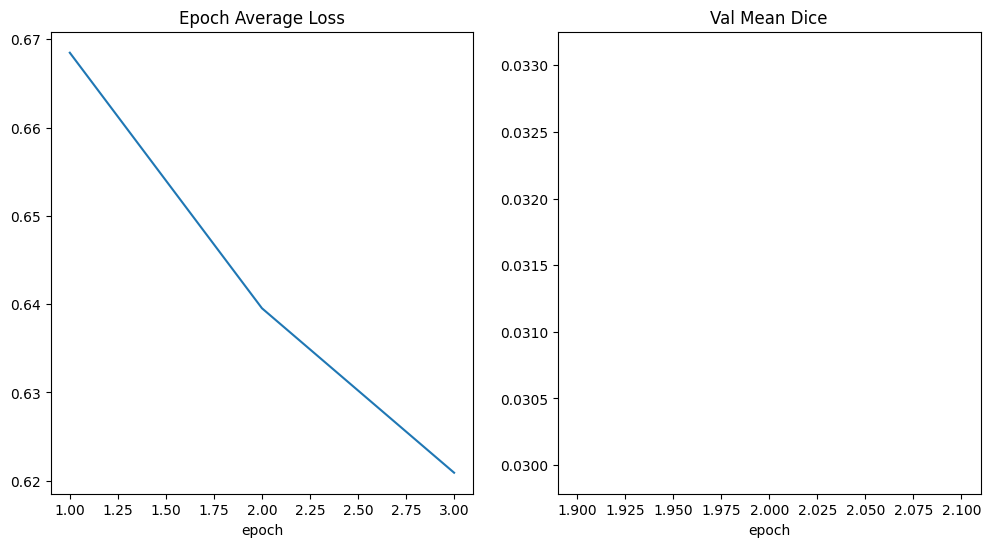

In [16]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

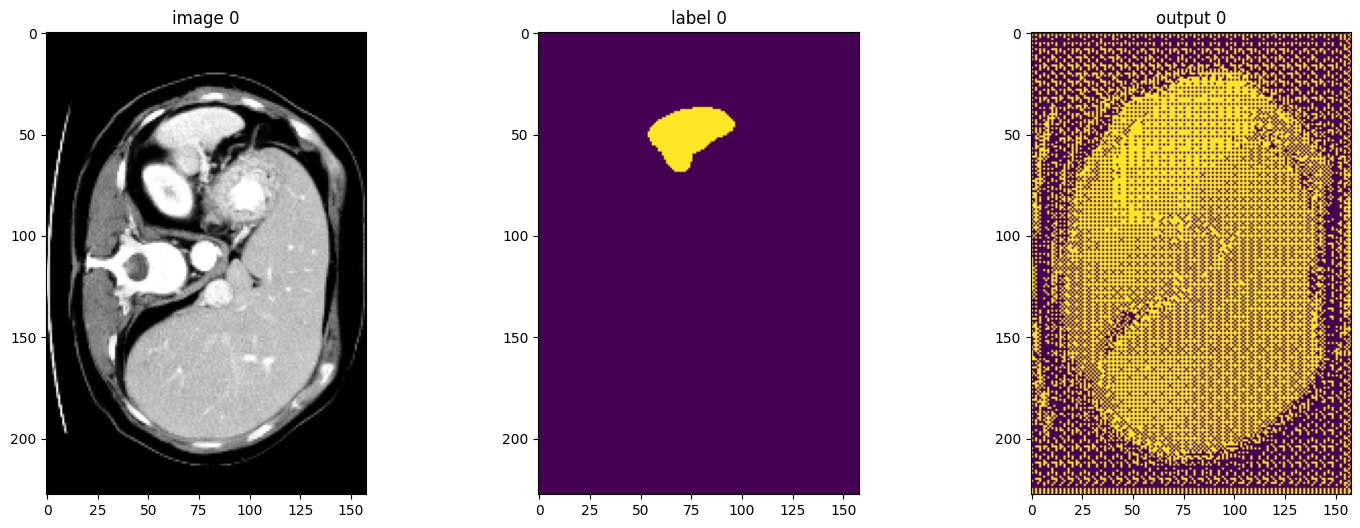

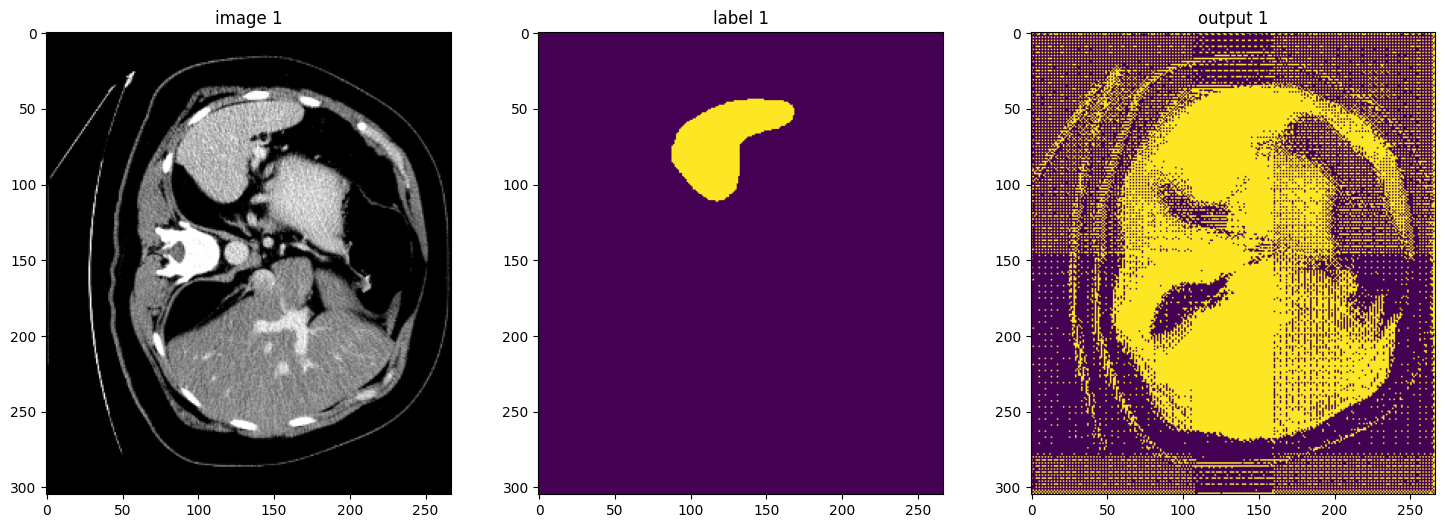

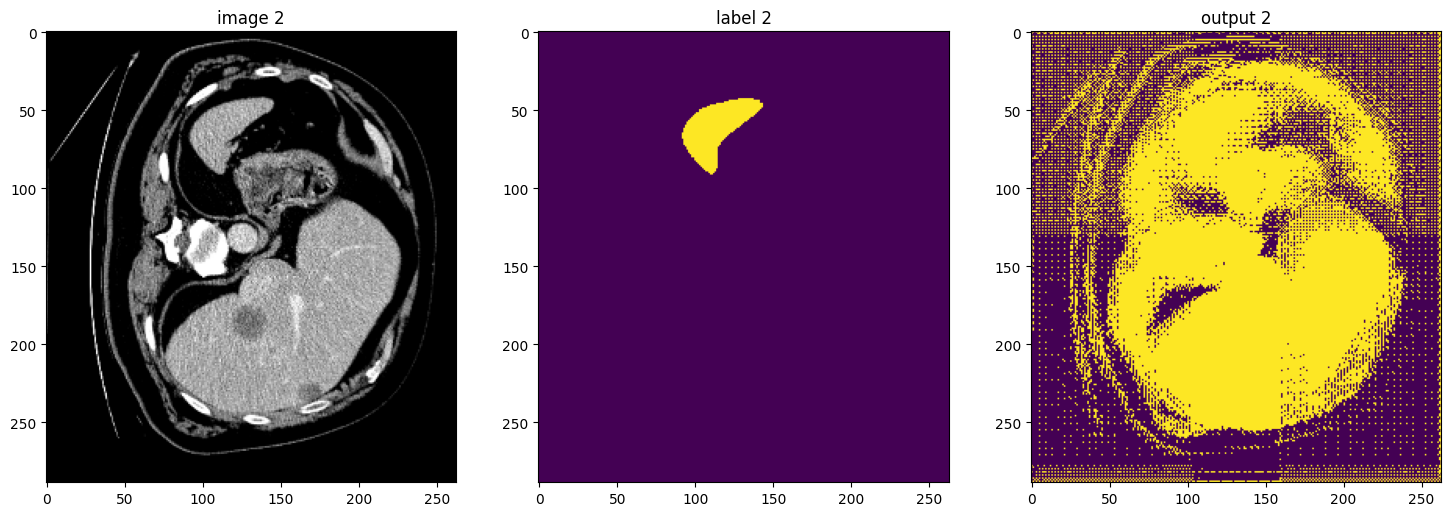

In [17]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth"), weights_only=True))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 2:
            break

## Evaluation on original image spacings

In [18]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image", allow_smaller=True),
    ]
)

val_org_ds = Dataset(data=val_files, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=val_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        AsDiscreted(keys="label", to_onehot=2),
    ]
)

monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.


In [19]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth"), weights_only=True))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)

Metric on original image spacing:  0.03733856976032257


## Inference on Test Set

In [20]:
test_images = sorted(glob.glob(os.path.join(final_data_dir, "imagesTs", "*.nii.gz")))

test_data = [{"image": image} for image in test_images]


test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image", allow_smaller=True),
    ]
)

test_org_ds = Dataset(data=test_data, transform=test_org_transforms)

test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=test_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
    ]
)

In [21]:
# # uncomment the following lines to visualize the predicted results
from monai.transforms import LoadImage
loader = LoadImage()

2025-11-09 22:34:17,379 INFO image_writer.py:197 - writing: out/spleen_1/spleen_1_seg.nii.gz


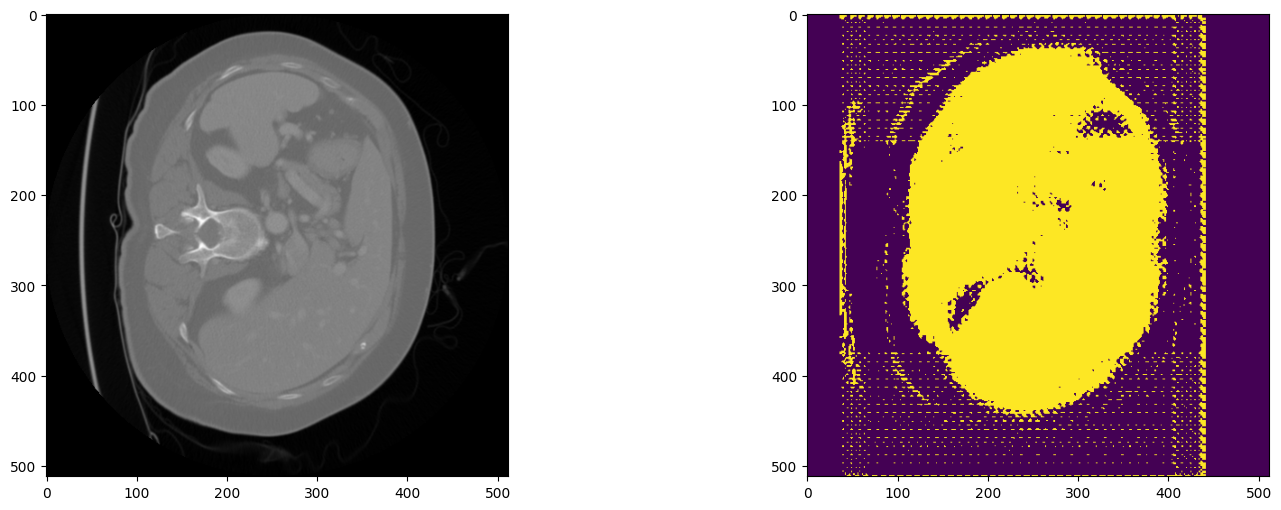

2025-11-09 22:34:19,787 INFO image_writer.py:197 - writing: out/spleen_11/spleen_11_seg.nii.gz


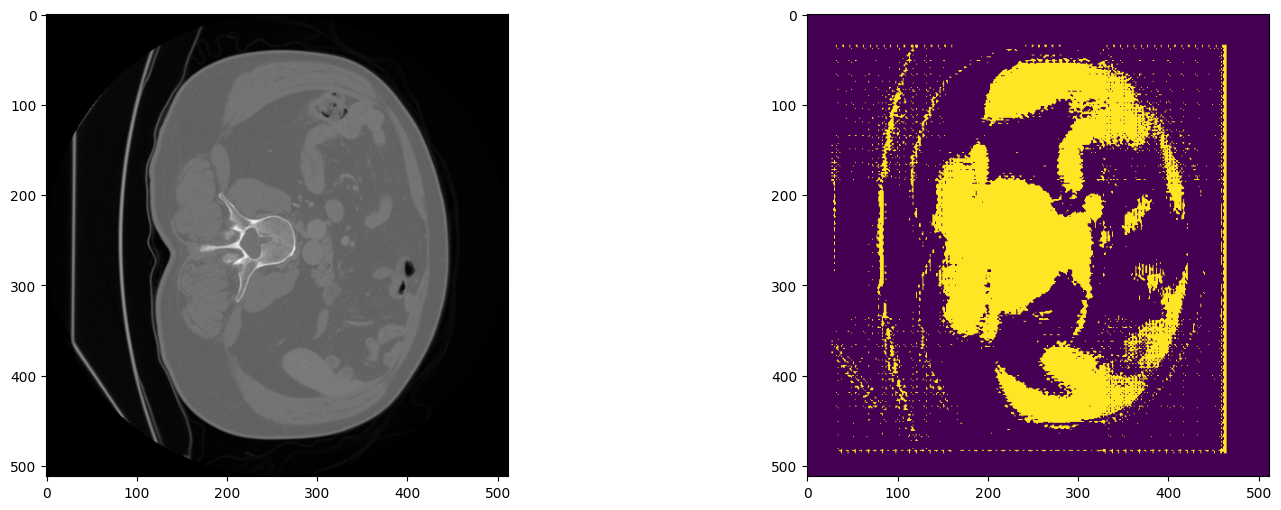

2025-11-09 22:34:25,421 INFO image_writer.py:197 - writing: out/spleen_15/spleen_15_seg.nii.gz


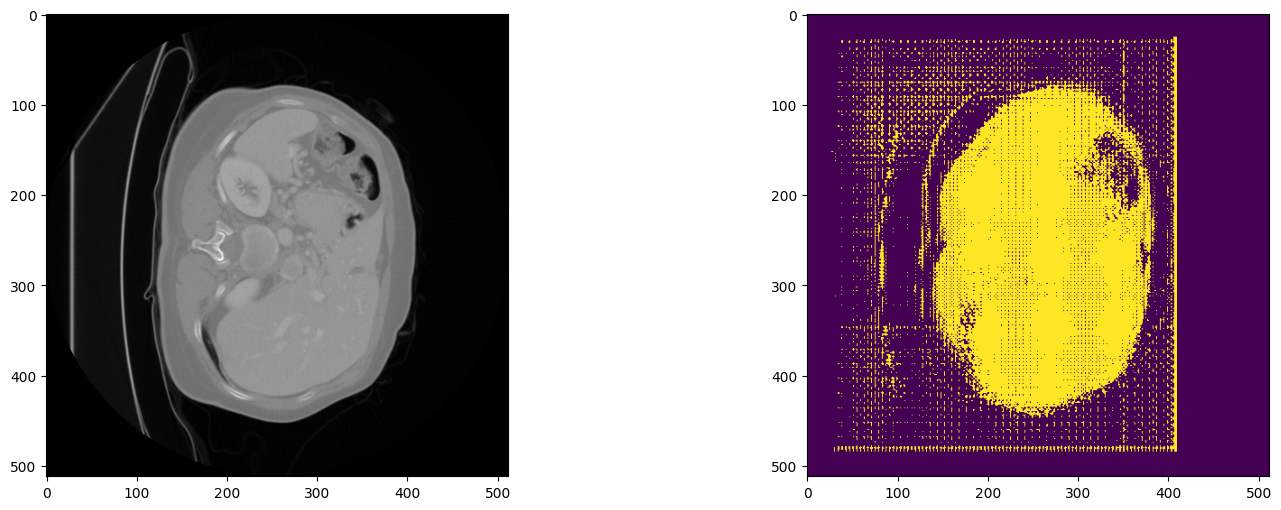

2025-11-09 22:34:27,064 INFO image_writer.py:197 - writing: out/spleen_23/spleen_23_seg.nii.gz


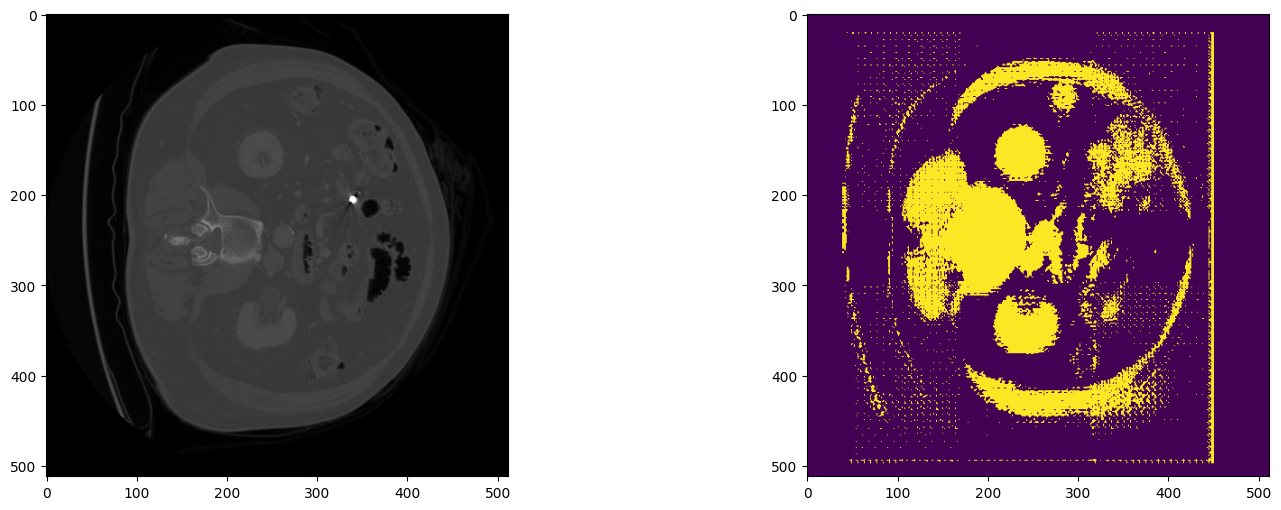

2025-11-09 22:34:31,980 INFO image_writer.py:197 - writing: out/spleen_30/spleen_30_seg.nii.gz


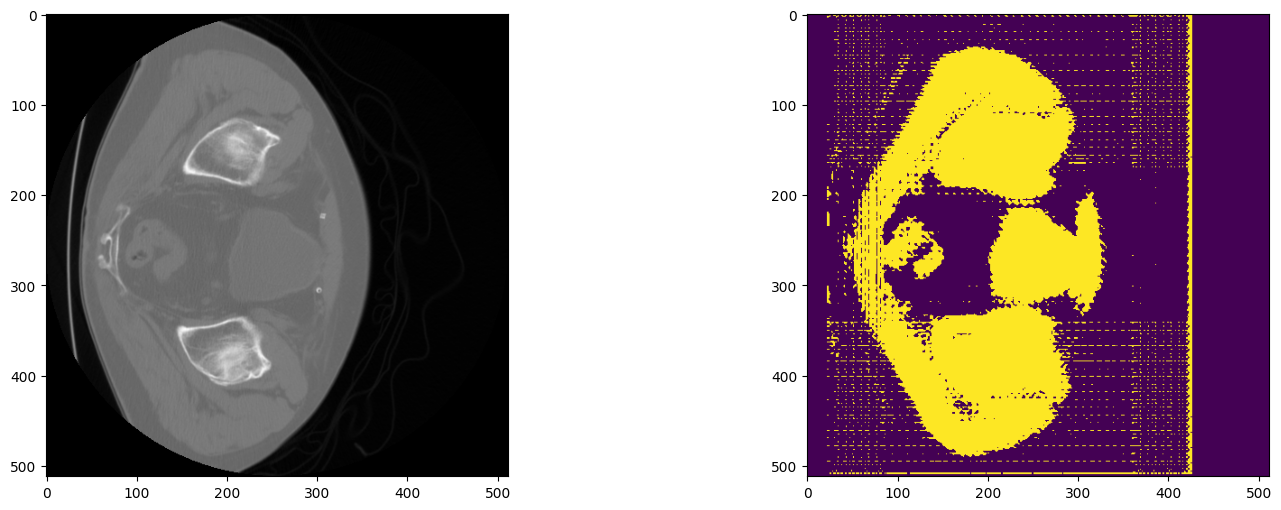

2025-11-09 22:34:36,929 INFO image_writer.py:197 - writing: out/spleen_34/spleen_34_seg.nii.gz


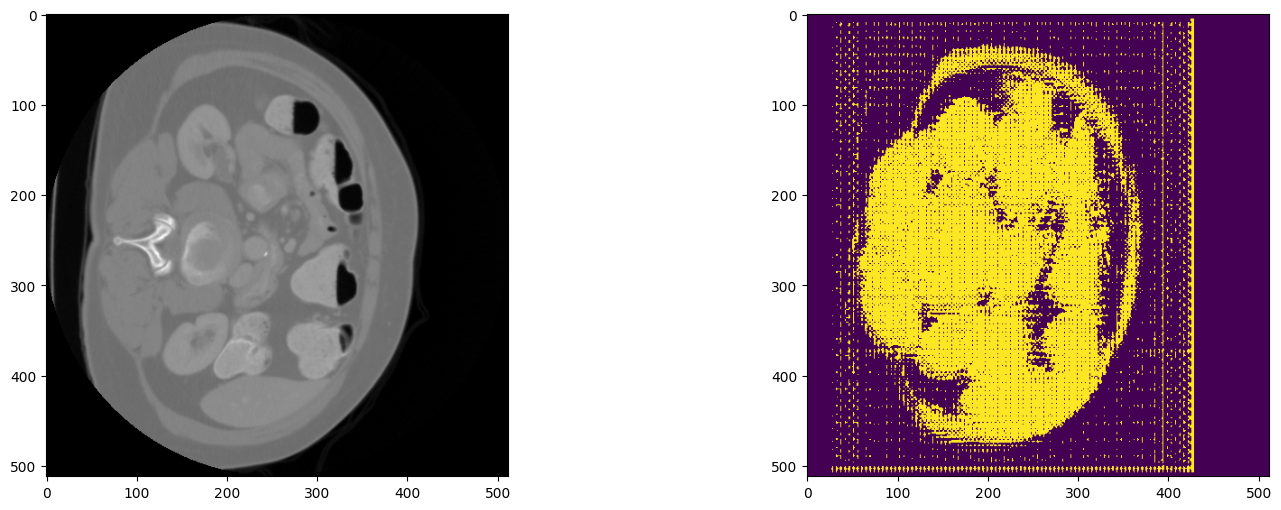

2025-11-09 22:34:38,856 INFO image_writer.py:197 - writing: out/spleen_35/spleen_35_seg.nii.gz


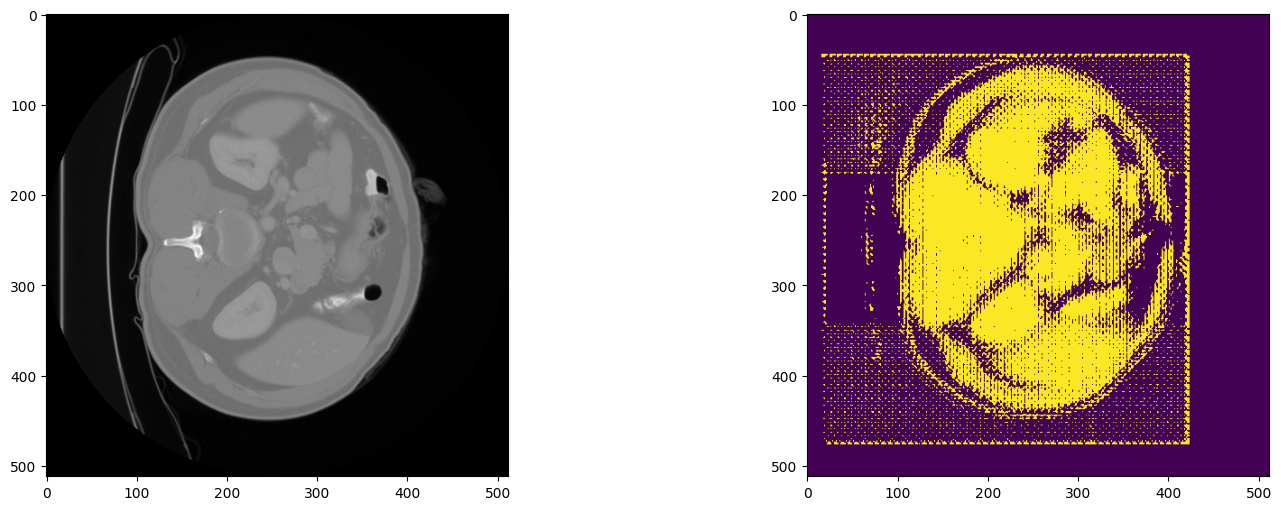

2025-11-09 22:34:41,022 INFO image_writer.py:197 - writing: out/spleen_36/spleen_36_seg.nii.gz


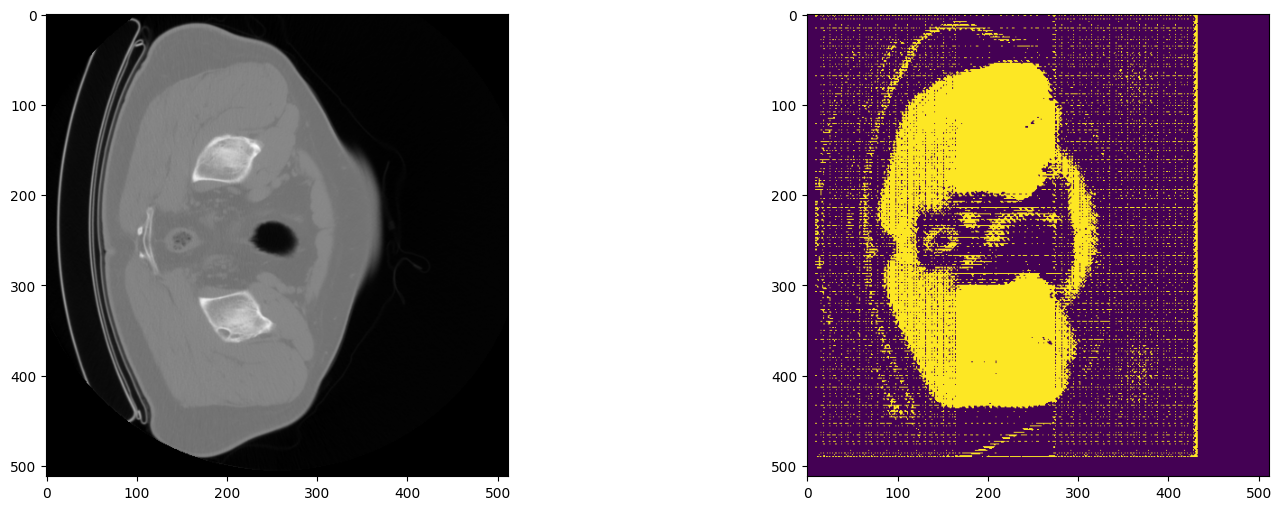

2025-11-09 22:34:45,557 INFO image_writer.py:197 - writing: out/spleen_37/spleen_37_seg.nii.gz


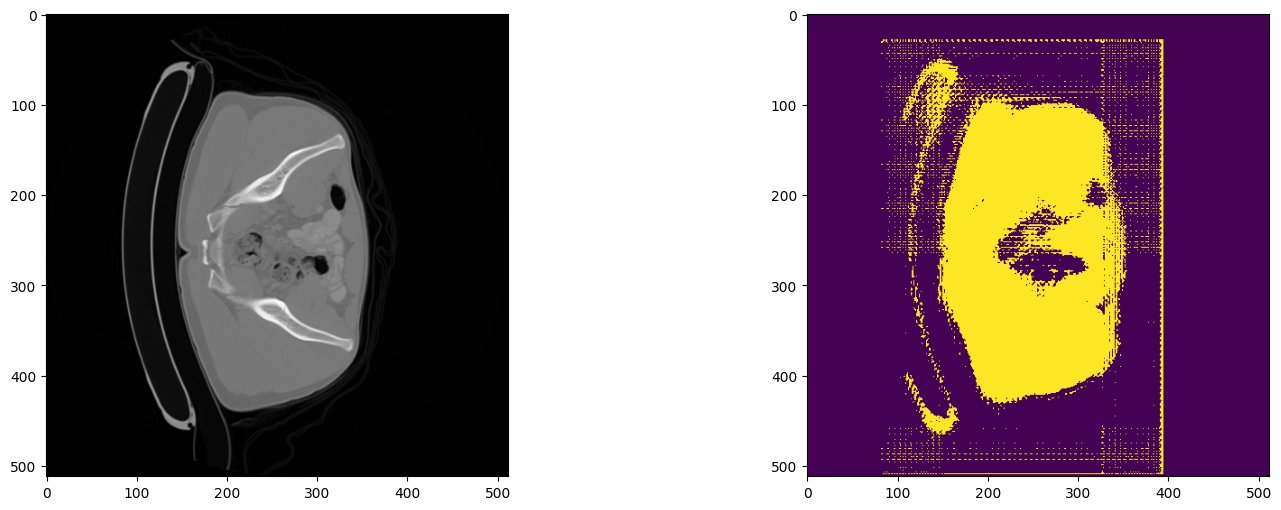

2025-11-09 22:34:52,120 INFO image_writer.py:197 - writing: out/spleen_39/spleen_39_seg.nii.gz


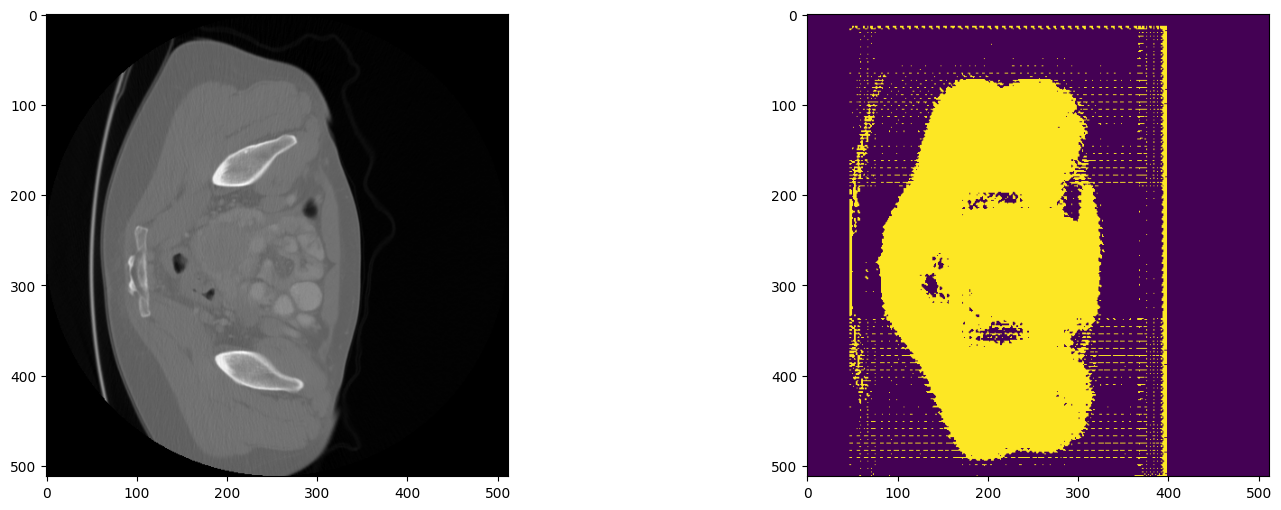

2025-11-09 22:34:55,917 INFO image_writer.py:197 - writing: out/spleen_42/spleen_42_seg.nii.gz


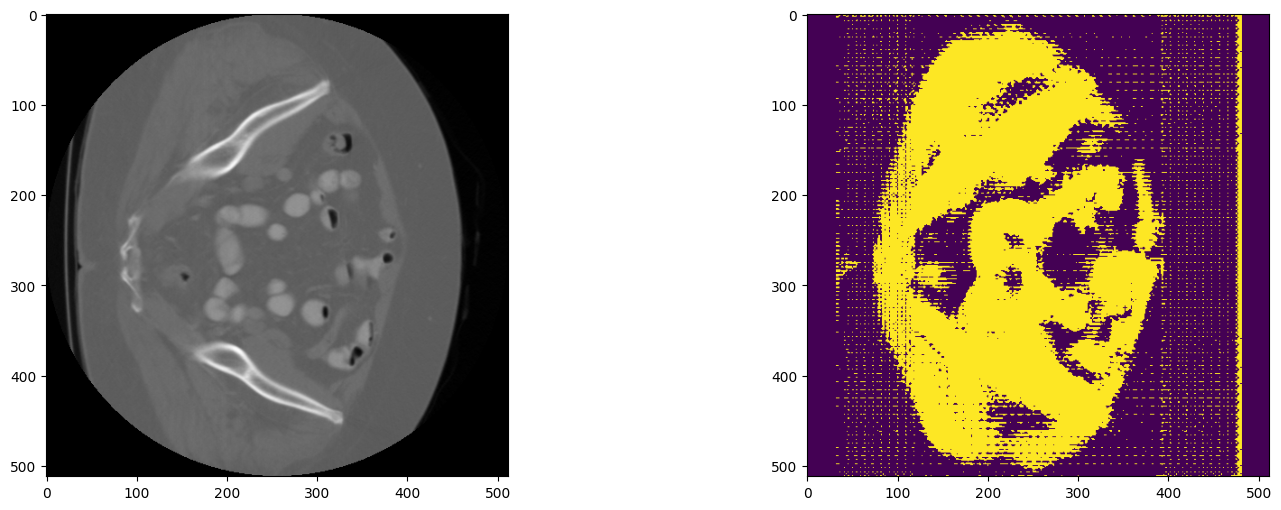

2025-11-09 22:34:59,965 INFO image_writer.py:197 - writing: out/spleen_43/spleen_43_seg.nii.gz


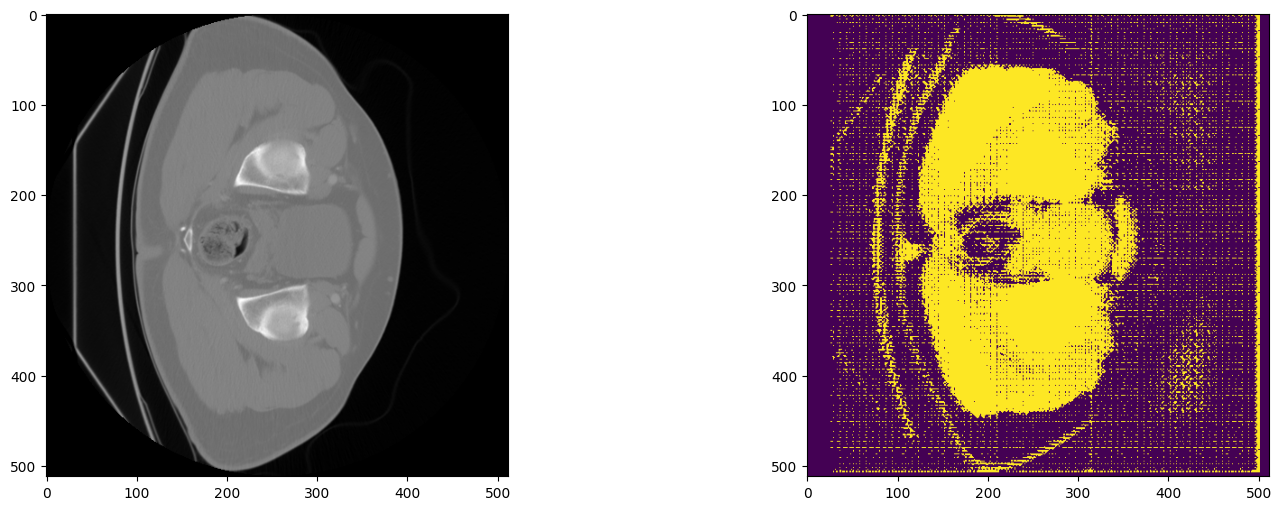

2025-11-09 22:35:04,078 INFO image_writer.py:197 - writing: out/spleen_48/spleen_48_seg.nii.gz


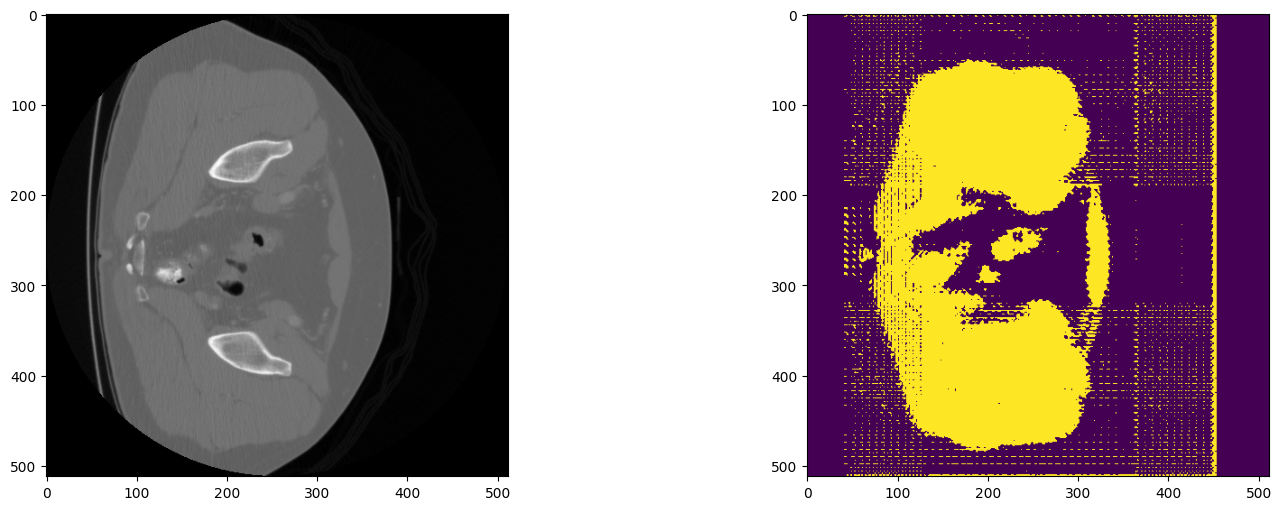

2025-11-09 22:35:08,193 INFO image_writer.py:197 - writing: out/spleen_50/spleen_50_seg.nii.gz


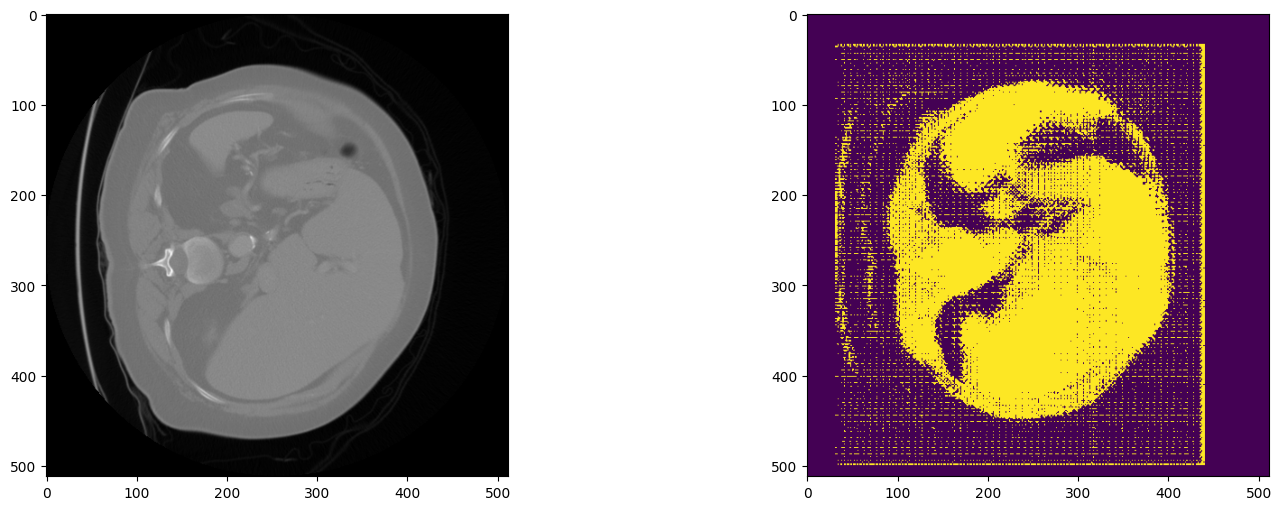

2025-11-09 22:35:10,068 INFO image_writer.py:197 - writing: out/spleen_51/spleen_51_seg.nii.gz


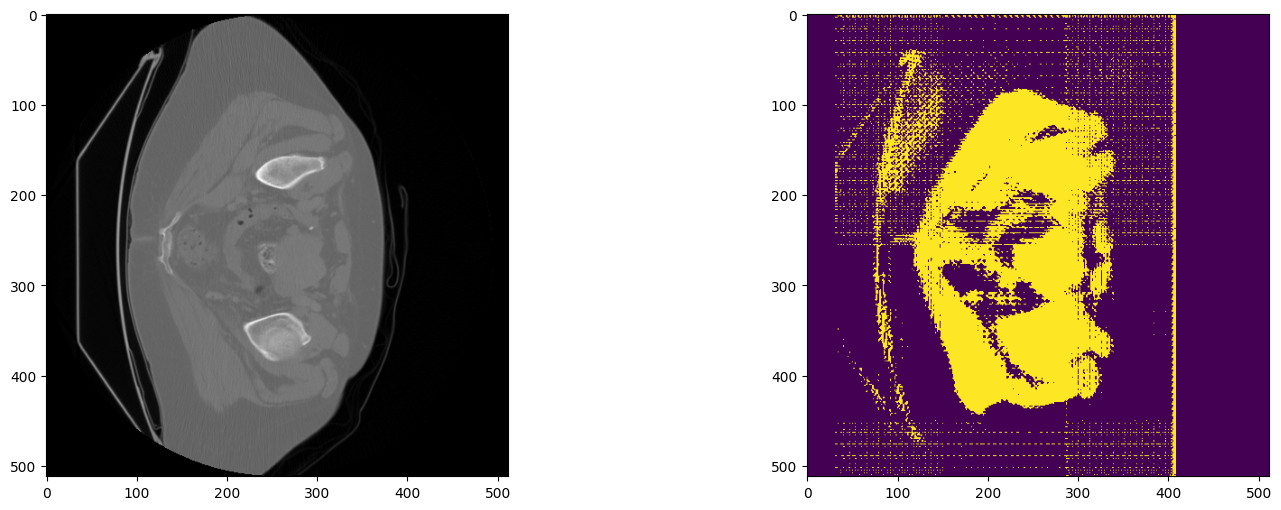

2025-11-09 22:35:13,908 INFO image_writer.py:197 - writing: out/spleen_54/spleen_54_seg.nii.gz


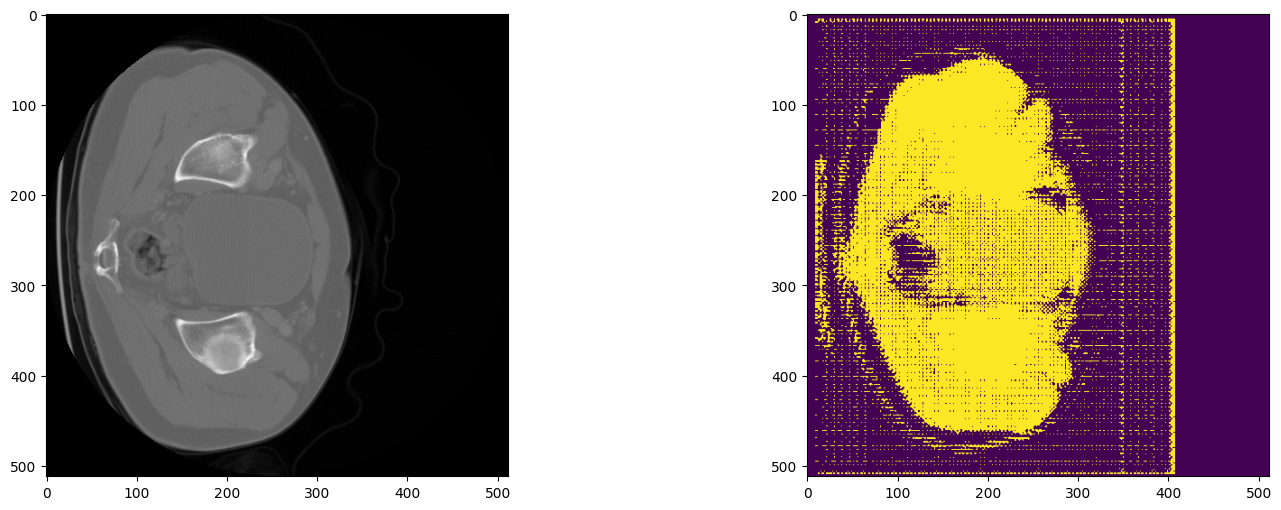

2025-11-09 22:35:17,745 INFO image_writer.py:197 - writing: out/spleen_55/spleen_55_seg.nii.gz


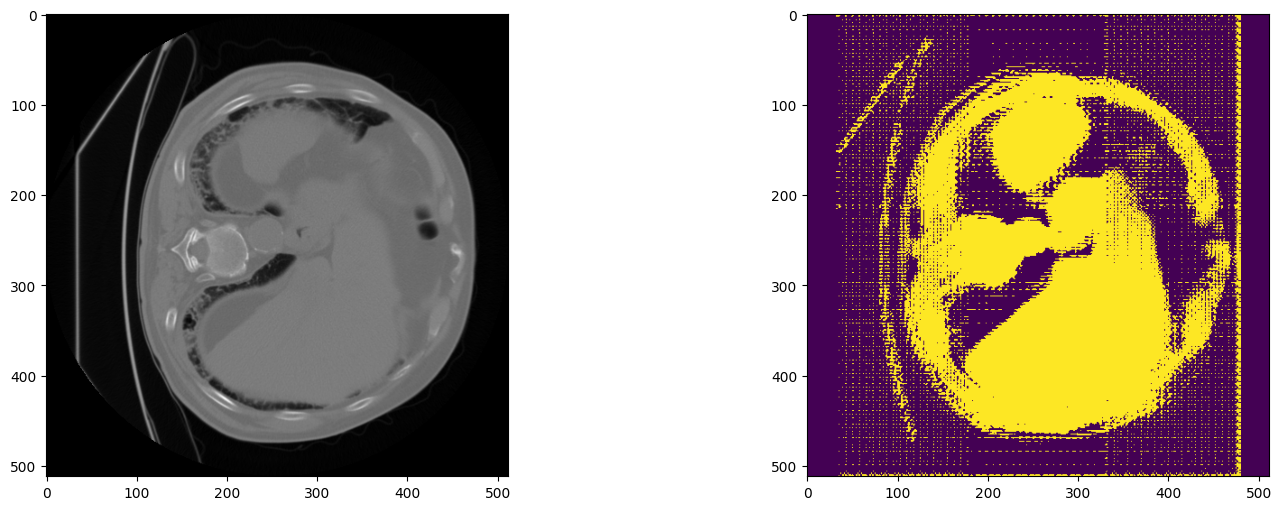

2025-11-09 22:35:20,490 INFO image_writer.py:197 - writing: out/spleen_57/spleen_57_seg.nii.gz


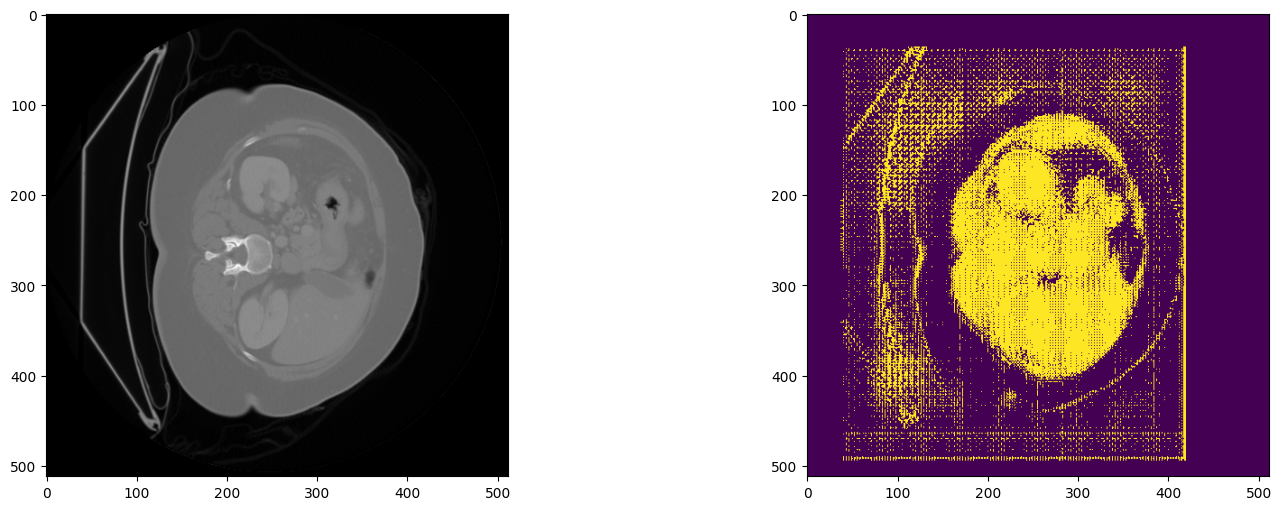

2025-11-09 22:35:22,743 INFO image_writer.py:197 - writing: out/spleen_58/spleen_58_seg.nii.gz


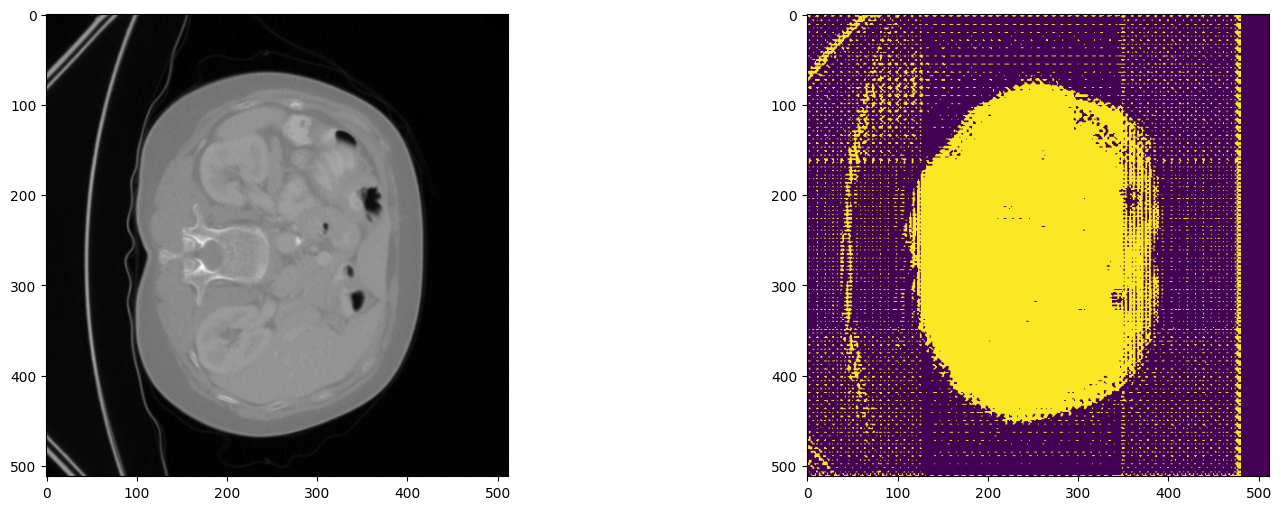

2025-11-09 22:35:24,991 INFO image_writer.py:197 - writing: out/spleen_7/spleen_7_seg.nii.gz


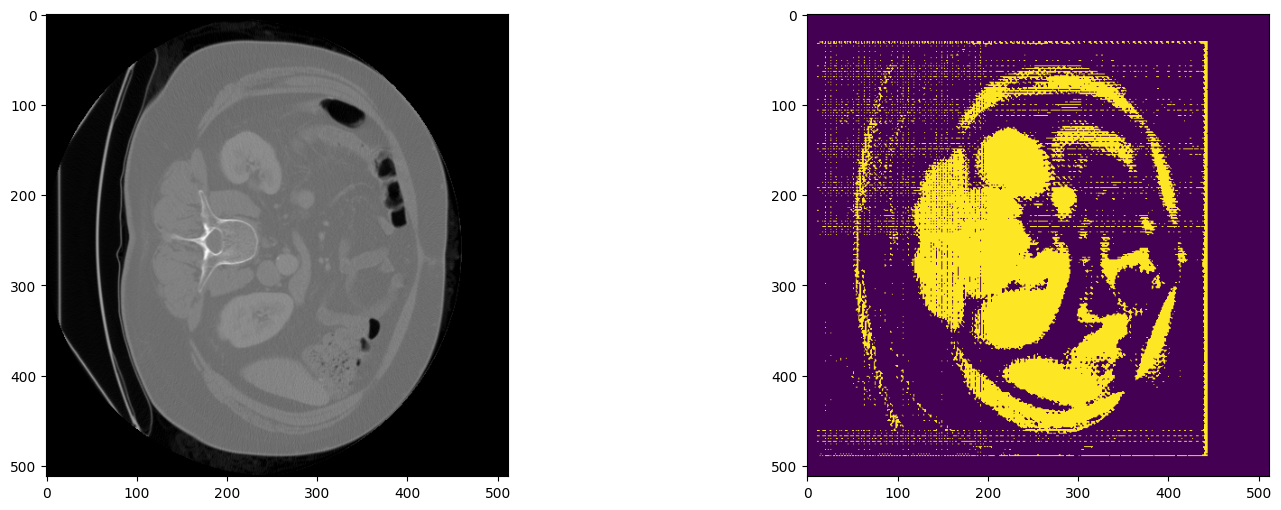

In [22]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth"), weights_only=True))
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]

        # uncomment the following lines to visualize the predicted results
        test_output = from_engine(["pred"])(test_data)

        original_image = loader(test_output[0].meta["filename_or_obj"])

        plt.figure("check", (18, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(original_image[:, :, 20], cmap="gray")
        plt.subplot(1, 2, 2)
        plt.imshow(test_output[0].detach().cpu()[1, :, :, 20])
        plt.show()